In [1]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import os

np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "training_linear_model"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

[about matplotlib](https://jrc-park.tistory.com/274)

# 선형 회귀

In [2]:
import numpy as np

X = 2 * np.random.rand(100 ,1) # 0 ~ 1 균일 분포 표준정규분포 난수
y = 4 + 3 * X + np.random.randn(100, 1) # 평균 0, 표준편차 1의 가우시안 표준정규분포 난수

그림 저장: generated_data_plot


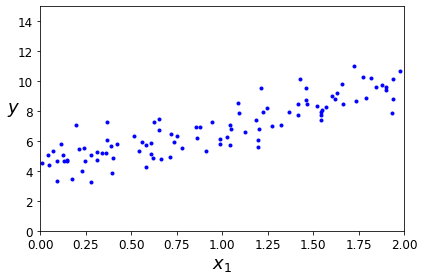

In [3]:
plt.plot(X, y, 'b.')
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18) # rotation : 'y' 표현
plt.axis([0, 2, 0, 15])
save_fig('generated_data_plot')
plt.show()

### 정규 방정식

$\theta^2=(X^TX)^−1X^Ty$

In [4]:
X_b = np.c_[np.ones((100, 1)), X] # 모든 샘플에 x0 = 1 추가
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[4.21509616],
       [2.77011339]])

In [5]:
X_new = np.array([[0],[2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.21509616],
       [9.75532293]])

그림 저장: linear_model_predictions_plot


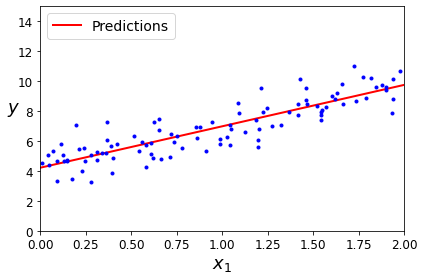

In [6]:
plt.plot(X_new, y_predict, "r-", linewidth=2, label="Predictions")
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 2, 0, 15])
save_fig("linear_model_predictions_plot")
plt.show()

In [7]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

$\hat{y}=X\hat{\theta}$

In [8]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

`Linear Regression` 클래스는 `scipy.linalg.lstsq()` 을 기반으로 함. 함수 직접 사용 가능

In [9]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.21509616],
       [2.77011339]])

이 함수는 $\hat{\theta} = X^+y$ 계산. $X^+$는 유사역행렬

In [10]:
np.linalg.pinv(X_b).dot(y)

array([[4.21509616],
       [2.77011339]])

## 경사 하강법
### 배치 경사 하강법 (batch gradient descent)

**그레이디언트 벡터** <br><br>
$\nabla_\theta MSE(\theta)=\frac{2}{m}X^T(X\theta−y)$ <br><br>
**경사 하강법 스텝** <br><br>
$\theta^{(next step)} = \theta - \eta\nabla_\theta MSE(\theta)$

In [11]:
eta = 0.1
n_iterations = 1000
m = 100

theta = np.random.randn(2, 1)

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta -= eta * gradients
theta

array([[4.21509616],
       [2.77011339]])

In [12]:
print(X_new)
print(X_new_b)
print(X_new_b.dot(theta))

[[0]
 [2]]
[[1. 0.]
 [1. 2.]]
[[4.21509616]
 [9.75532293]]


In [13]:
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients # -= 로 할 경우 ??
        if theta_path is not None:
            theta_path_bgd.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title("$\eta = {}$".format(eta), fontsize=18)

그림 저장: gradient_descent_plot


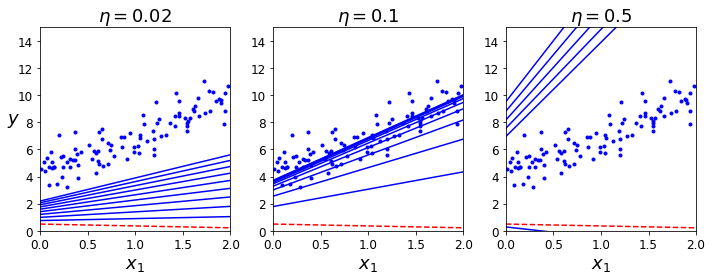

In [14]:
np.random.seed(42)
theta = np.random.randn(2,1)

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, 0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, 0.1, theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, 0.5)

save_fig("gradient_descent_plot")
plt.show()

### 확률적 경사 하강법 (stochastic gradient descent)
- 매 스텝에서 한 개의 샘플을 무작위 선택, 그 샘플에 대한 gradient 계산
- 확룰적(무작위)이므로 불안정, 최솟값 다다를 때까지 요동치며 감소
- 불규칙 -> 지역 최솟값 건너뛰고 전역 최솟값 찾을 가능성 높음 But, 전역 최솟값에 다다르지 못하게 할 수도 있음
- 이를 해결 위해 **학습률을 점진적으로 감소**
- (금속 공학 분야의 담금질 기법 알고리즘과 유사)

In [15]:
theta_path_sgd = []
m = len(X_b)

일반적으로 한 반복에서 m번 되풀이하고, 이 때 각 반복을 **에포크(epoch)** 라고 함

그림 저장: sgd_plot


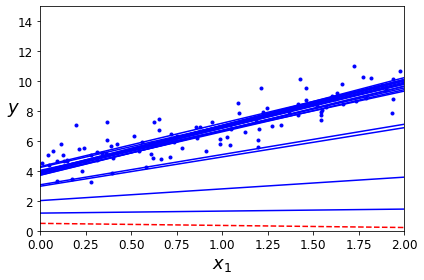

In [16]:
np.random.seed(42)
n_epochs = 50
t0, t1 = 5, 50 # 학습 스케줄 하이퍼파라미터

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2, 1)

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:
            y_predict = X_new_b.dot(theta)
            style = "b-" if i > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)

plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
save_fig("sgd_plot")
plt.show()

In [17]:
theta

array([[4.21076011],
       [2.74856079]])

In [18]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel()) # ravel() : 다차원 배열을 1차원 배열로 풀어줌

SGDRegressor(eta0=0.1, penalty=None)

- 최대 1000번 에포크
- 한 에포크에서 0.001보다 적게 손실이 줄어들 때까지 (tol=1e-3)
- 학습률 0.1로 기본 학습 스케줄 (eta-0.1)
- SGDRegressor 의 `fit` 은 `y`로 1d array을 요구함

In [19]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.23868557]), array([2.82181634]))

### 미니배치 경사 하강법 (mini-batch gradient descent)
- 각 스텝에서 전체 훈련 세트나 하나의 샘플이 아닌 **미니배치**라 부르는 임의의 작은 샘플에 대해 gradient 계산
- 장점 : 행렬 연산에 최적화된 하드웨어, GPU를 사용해서 얻는 성능 향상
- SGD에 비해 덜 불규칙함

In [20]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2, 1)
t0, t1 = 200, 1000

def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)
theta

array([[4.25214635],
       [2.7896408 ]])

[- vs -= operatios with numpy](https://stackoverflow.com/questions/9047111/vs-operators-with-numpy)

In [21]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)
theta_path_bgd[:, 0][0], theta_path_bgd[:, [0]][0]

(array([1.78737583]), array([[1.78737583]]))

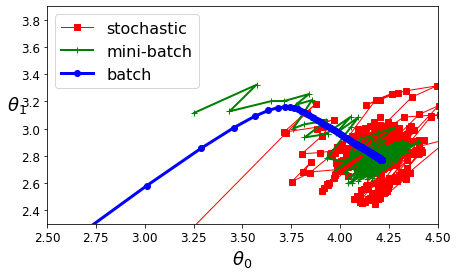

In [22]:
plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="batch")
plt.legend(loc="upper left", fontsize=16) # r'' -> raw string
plt.xlabel(r"$\theta_0$", fontsize=18)
plt.ylabel(r"$\theta_1$", rotation=0, fontsize=18)
plt.axis([2.5, 4.5, 2.3, 3.9])
plt.show()

[`np.array[:,0]` vs `np.array[:,[0]]`](https://stackoverflow.com/questions/48858377/whats-the-difference-between-np-array-0-and-np-array-0)

## 다항 회귀

In [23]:
import numpy as np
import numpy.random as nrd

In [24]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

그림 저장: quadratic_data_plot


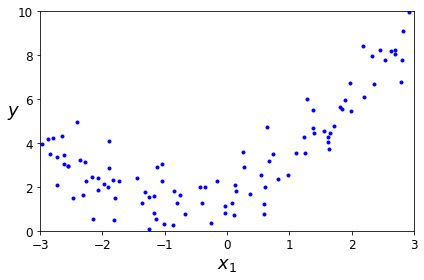

In [25]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_data_plot")
plt.show()

In [26]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0], X_poly[0]

(array([-0.75275929]), array([-0.75275929,  0.56664654]))

**PolynomialFeatures** : degree의 기본값은 2, include_bias의 기본값은 True (편향을 위한 특성($x_0$)인 1이 추가)

In [27]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_, lin_reg.score(X_poly,y)

(array([1.78134581]), array([[0.93366893, 0.56456263]]), 0.8525067519009746)

그림 저장: quadratic_predictions_plot


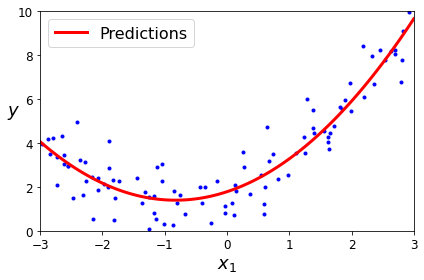

In [28]:
X_new = np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new) # fit_transform 해도 상관 없나?  -> X
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=3, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=16)
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_predictions_plot")
plt.show()

[`fit_transform` vs `transform`](https://khalidpark2029.tistory.com/82]) <br>
 ✔ PolynomialFeatures의 `fit`은 뭘 수행하나? -> [scikit-learn github](https://github.com/scikit-learn/scikit-learn/blob/7e1e6d09b/sklearn/preprocessing/_polynomial.py#L270)

0.9301963848496299
0.8525067519009746
0.4260082378913981
그림 저장: high_degree_polynomials_plot


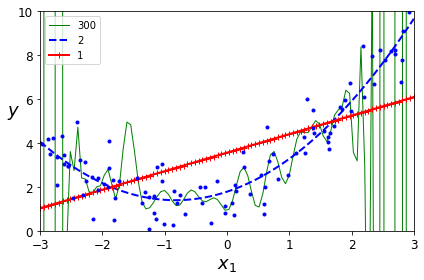

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    ss = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
        ("poly_features", polybig_features),
        ("ss", ss),
        ("lin_reg", lin_reg),
    ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)
    print(polynomial_regression.score(X, y))

plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left")
plt.axis([-3, 3, 0, 10])
save_fig("high_degree_polynomials_plot")
plt.show()

### 학습 곡선(learning curve)
- 모델이 데이터에 과대적합 or 과소적합되었는지 판단
- 훈련 세트와 검증 세트의 모델 성능을 훈련 세트 크기(또는 훈련 반복)의 함수로 나타냄

In [30]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train) + 1):
        model.fit(X_train[:m], y_train[:m])
        X_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], X_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)
    plt.xlabel("Training set size", fontsize=14)
    plt.ylabel("RMSE", fontsize=14)

`plt.plot(np.array)` : 배열 인덱스를 x축에 자동으로 맞추어줌

그림 저장: underfitting_learning_curves_plot


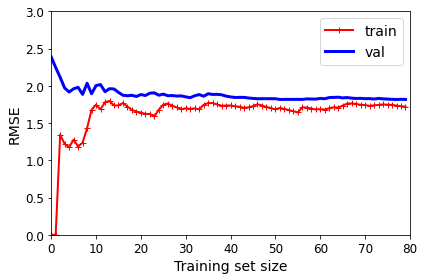

In [31]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])
save_fig("underfitting_learning_curves_plot")
plt.show()

- 두 곡선이 수평한 구간을 만들고 꽤 높은 오차에서 매우 가까이 근접해 있음 -> 과소적합 모델의 전형적 모습
- 과소적합되어 있다면 훈련샘플을 더 추가해도 효과가 없음. 복잡한 모델 사용 or 더 나은 특성 사용

그림 저장: overfitting_learning_curves_plot


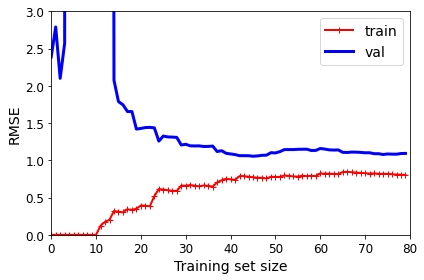

In [32]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
    ("lin_reg", LinearRegression()),
])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])
save_fig("overfitting_learning_curves_plot")
plt.show()

- 훈련 데이터의 오차가 이전 선형 회귀 모델보다 훨씬 낮음
- 두 곡선 사이의 공간 -> 검증 데이터에서보다 훈련 데이터에서의 성능이 훨씬 낫다는 뜻 -> **과대적합**
- 더 큰 훈련 세트 사용 시 두 곡선이 점점 가까워짐
- 과대적합 해결 방법 : 검증 오차가 훈련 오차에 더 근접할 때까지 더 많은 훈련 데이터 추가

## 규제가 있는 선형 모델
- 과대적합을 감소시키는 방법 (모델의 가중치를 제한)
- 릿지, 라쏘, 엘라스틱

### 릿지 회귀

$J(\theta) = MSE(\theta) + \alpha\frac{1}{2}\sum_{i=1}^n\theta_i^2$

In [33]:
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

릿지 회귀를 계산하기 위해 정규방정식을 사용할 수도 있고, 경사하강법 사용 가능

### 릿지 회귀의 정규 방정식

$\hat{\theta} = (X^TX + \alpha A)^{-1}X^Ty$

- 사이킷런에서 정규방정식을 사용한 릿지 회귀를 적용하는 예

In [34]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55071465]])

- 확률적 경사 하강법을 사용하는 예
    - 확률적 평균 경사 하강법(stochastic average gradient descent)
    - SGDRegressor

In [35]:
ridge_reg = Ridge(alpha=1, solver="sag", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.5507201]])

In [36]:
sgd_reg = SGDRegressor(penalty="l2", max_iter=1000, tol=1e-3, random_state=42)
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([1.47012588])

- **하이퍼파라미터 $\alpha$ 는 모델을 얼마나 많이 규제할지 조절**
- $\alpha = 0$ 이면 릿지 회귀는 선형 회귀와 같아짐
- $\alpha$ 가 아주 크면 모든 가중치가 거의 0에 가까워지고 결국 데이터의 평균을 지나는 수평선이 됨 
- $\alpha$ 증가 -> 모델의 **분산 감소, 편향 증가 (과대적합 감소)**

그림 저장: ridge_regression_plot


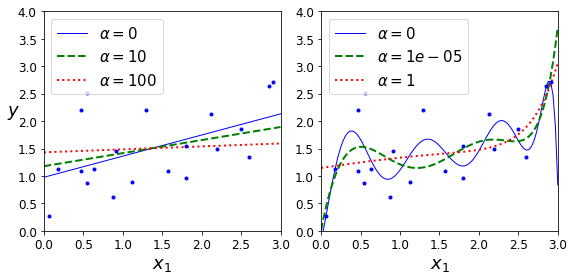

In [37]:
from sklearn.linear_model import Ridge

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("ss", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])
        
plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

save_fig("ridge_regression_plot")
plt.show()

### 라쏘 회귀

$J(\theta) = MSE(\theta) + \alpha\sum_{i=1}^n\left\vert\theta_i\right\vert$

C:\Users\yucha\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.802867703827432, tolerance: 0.0009294783355207351
  model = cd_fast.enet_coordinate_descent(


그림 저장: lasso_regression_plot


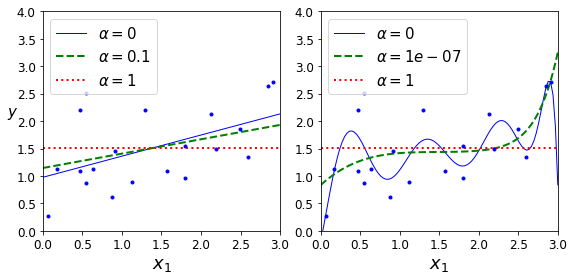

In [38]:
from sklearn.linear_model import Lasso

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=15)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), random_state=42)

save_fig("lasso_regression_plot")
plt.show()

- ~~$\alpha = 0$ 일 때 Ridge, Lasso 모두 LinearRegression 인데 왜 결과가 다른가~~
- $\alpha$ 가 커지면 덜 중요한 특성의 가중치를 제거 -> $\alpha = 1$ 일 때 모두 0

In [39]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]]), lasso_reg.score(X,y)

(array([1.53788174]), 0.23186890791971937)

### 엘라스틱넷
- 릿지 회귀와 라쏘 회귀를 절충한 모델
- 혼합 비율 $r$
- $r=0$ 이면 릿지 회귀, $r=1$이면 라쏘 회귀

$J(\theta) = MSE(\theta) + r\alpha\sum_{i=1}^n\left\vert\theta_i\right\vert + \frac{1-r}{2}\alpha\sum_{i=1}^n\theta_i^2$

- 릿지가 기본이지만 특성이 몇 개뿐이라고 의심되면 라쏘 or 엘라스틱넷
- 라쏘, 엘라스틱넷은 불필요한 특성의 가중치를 0으로 만들어줌
- 특성 수가 훈련 샘플 수보다 많거나 특성 몇 개가 강하게 연관 -> 라쏘가 문제를 일으킴 -> 엘라스틱넷

In [40]:
from sklearn.linear_model import ElasticNet

elasticnet_reg = ElasticNet(alpha=0.1, l1_ratio=0.5)
elasticnet_reg.fit(X,y)
elasticnet_reg.predict([[1.5]]), elasticnet_reg.score(X,y)

(array([1.54333232]), 0.24714060732259002)

### 조기 종료
- 검증 에러가 최솟값에 도달하면 바로 훈련을 중지

In [41]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

- 왜 50개만 쓰지?

In [42]:
from copy import deepcopy

poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("ss", StandardScaler())
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val) # fit_transform 하지 않게 주의합시다..

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                      penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = deepcopy(sgd_reg)

In [43]:
best_epoch, best_model

(239,
 SGDRegressor(eta0=0.0005, learning_rate='constant', max_iter=1, penalty=None,
              random_state=42, tol=-inf, warm_start=True))

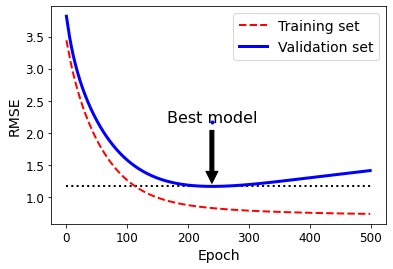

In [44]:
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                      penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)
n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.plot(best_epoch, best_val_rmse + 1, "b.") # for checking param('ha', 'va') of pyplot.annotate()
plt.annotate("Best model",
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor="black", shrink=0.05),
             fontsize=16,
            )

plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
# save_fig("early_stopping_plot")
plt.show()

In [45]:
best_epoch, best_val_rmse

(239, 1.1624590535779689)

In [46]:
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                      penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

X_test_poly_scaled = poly_scaler.transform(X[50:])

for epoch in range(best_epoch + 1):
    sgd_reg.fit(X_train_poly_scaled, y_train)

sgd_reg.score(X_test_poly_scaled, y[50:])

-0.6570073838966353

### 로지스틱 회귀

- 샘플이 특정 클래스에 속할 확률을 추정
- 추정 확률이 50%가 넘으면 양성 클래스, 아니면 음성 클래스
- 작동 원리
    - 선형 회귀 모델과 같이 입력 특성의 가중치 합을 계산(그리고 편향 더함)
    - 결괏값의 **로지스틱(logistic)** 출력
    - 로지스틱($\sigma(\cdot)$)은 0과 1 사이의 값을 출력하는 **시그모이드 함수(sigmoid function)**
    
$\hat{p} = h_\theta(x) = \sigma(\theta^Tx)$

그림 저장: logistic_function_plot


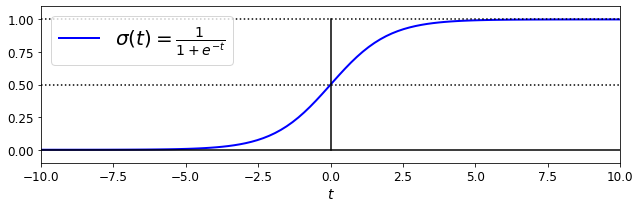

In [47]:
t = np.linspace(-10, 10, 100)
sig = 1 / (1 + np.exp(-t))
plt.figure(figsize=(9, 3))
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \frac{1}{1 + e^{-t}}$")
plt.plot([-10, 10], [0, 0], "k-")
plt.plot([-10, 10], [0.5, 0.5], "k:")
plt.plot([-10, 10], [1, 1], "k:")
plt.plot([0, 0], [0, 1], "k-")
plt.legend(loc="upper left", fontsize=20)
plt.xlabel("$t$")
plt.axis([-10, 10, -0.1, 1.1])
save_fig("logistic_function_plot")
plt.show()

$\hat{y} = 
\begin{cases}
0 & \mbox{if } \hat{p} < 0.5  \\
1 & \mbox{if } \hat{p} \ge 0.5
\end{cases}$

$t < 0$ 이면 $\hat{p} = \sigma(t) < 0.5$ <br>
$t \ge 0$ 이면 $\hat{p} = \sigma(t) \ge 0.5$

$\therefore \theta^Tx$ 가 양수일 때 1(양성 클래스), 음수일 때 0 (음성 클래스) 

### 훈련 방법

- 목적: 양성 샘플($y=1$)에 대해 높은 확률 추정, 음성 샘플($y=0$)에 대해 낮은 확률 추정하는 파라미터 벡터 $\theta$ 찾기
- 하나의 훈련 샘플에 대한 비용 함수

$c(\theta) = 
\begin{cases}
-\mbox{log}(\hat{p}) & \mbox{if } \mbox{y = 1,} \\
-\mbox{log}(1 - \hat{p}) & \mbox{if } \mbox{y = 0}
\end{cases}
$

- $\hat{p}$가 0에 가까워지면 $-\mbox{log}(\hat{p})$ 가 매우 커짐 
- 즉, 양성 샘플을 0에 가까운 확률로 추정하면 비용이 크게 증가
- 음성 샘플을 1에 가깝게 추정하면 비용이 크게 증가

### 로그 손실(log loss)

- 로그 손실(로지스틱 회귀의 비용 함수) : 전체 훈련 세트에 대한 비용 함수는 모든 훈련 샘플의 비용을 평균한 것

$J(\theta) = - \frac{1}{m}\sum_{i=1}^m [y^{(i)}\mbox{log}(\hat{p}^{(i)}) + (1 - y^{(i)})\mbox{log}(1 - \hat{p}^{(i)})]$

- 비용 함수의 최솟값을 계산하는 알려진 해가 없음
- 볼록 함수이므로 경사 하강법이 전역 최솟값을 찾는 것을 보장
- 로그 손실의 편도함수

$\frac{∂}{∂\theta_j}J(\theta) = \frac{1}{m}\sum_{i=1}^m(\sigma(\theta^Tx^{(i)}) - y^{(i)})x_j^{(i)}$

In [48]:
from sklearn import datasets
iris = datasets.load_iris()
print(list(iris.keys()))
print(iris.data) # sepal length, sepal width, petal length, petal width

['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename']
[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]
 [4.6 3.4 1.4 0.3]
 [5.  3.4 1.5 0.2]
 [4.4 2.9 1.4 0.2]
 [4.9 3.1 1.5 0.1]
 [5.4 3.7 1.5 0.2]
 [4.8 3.4 1.6 0.2]
 [4.8 3.  1.4 0.1]
 [4.3 3.  1.1 0.1]
 [5.8 4.  1.2 0.2]
 [5.7 4.4 1.5 0.4]
 [5.4 3.9 1.3 0.4]
 [5.1 3.5 1.4 0.3]
 [5.7 3.8 1.7 0.3]
 [5.1 3.8 1.5 0.3]
 [5.4 3.4 1.7 0.2]
 [5.1 3.7 1.5 0.4]
 [4.6 3.6 1.  0.2]
 [5.1 3.3 1.7 0.5]
 [4.8 3.4 1.9 0.2]
 [5.  3.  1.6 0.2]
 [5.  3.4 1.6 0.4]
 [5.2 3.5 1.5 0.2]
 [5.2 3.4 1.4 0.2]
 [4.7 3.2 1.6 0.2]
 [4.8 3.1 1.6 0.2]
 [5.4 3.4 1.5 0.4]
 [5.2 4.1 1.5 0.1]
 [5.5 4.2 1.4 0.2]
 [4.9 3.1 1.5 0.2]
 [5.  3.2 1.2 0.2]
 [5.5 3.5 1.3 0.2]
 [4.9 3.6 1.4 0.1]
 [4.4 3.  1.3 0.2]
 [5.1 3.4 1.5 0.2]
 [5.  3.5 1.3 0.3]
 [4.5 2.3 1.3 0.3]
 [4.4 3.2 1.3 0.2]
 [5.  3.5 1.6 0.6]
 [5.1 3.8 1.9 0.4]
 [4.8 3.  1.4 0.3]
 [5.1 3.8 1.6 0.2]
 [4.6 3.2 1.4 0.2]
 [5.3 

In [49]:
print(iris["DESCR"])

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [50]:
X = iris["data"][:, 3:] # 꽃잎의 너비 ( 주의. 3: 로 설정해야 함 ) 
y = (iris["target"] == 2).astype(int) # Iris_Virginica 면 1, 그렇지 않으면 0

In [51]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X, y)

LogisticRegression()

In [52]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new) # 확률 반환

decision_boundary=X_new[y_proba[:, 1] >= 0.5][0]
X_new[y_proba[:, 1] >= 0.5]

array([[1.66066066],
       [1.66366366],
       [1.66666667],
       [1.66966967],
       [1.67267267],
       [1.67567568],
       [1.67867868],
       [1.68168168],
       [1.68468468],
       [1.68768769],
       [1.69069069],
       [1.69369369],
       [1.6966967 ],
       [1.6996997 ],
       [1.7027027 ],
       [1.70570571],
       [1.70870871],
       [1.71171171],
       [1.71471471],
       [1.71771772],
       [1.72072072],
       [1.72372372],
       [1.72672673],
       [1.72972973],
       [1.73273273],
       [1.73573574],
       [1.73873874],
       [1.74174174],
       [1.74474474],
       [1.74774775],
       [1.75075075],
       [1.75375375],
       [1.75675676],
       [1.75975976],
       [1.76276276],
       [1.76576577],
       [1.76876877],
       [1.77177177],
       [1.77477477],
       [1.77777778],
       [1.78078078],
       [1.78378378],
       [1.78678679],
       [1.78978979],
       [1.79279279],
       [1.7957958 ],
       [1.7987988 ],
       [1.801

`zip()` : 길이가 같은 리스트의 요소를 묶어줌

그림 저장: logistic_regression_plot


C:\Users\yucha\anaconda3\lib\site-packages\matplotlib\patches.py:1390: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  verts = np.dot(coords, M) + (x + dx, y + dy)


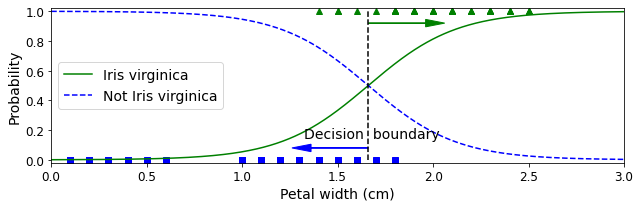

In [53]:
def plot_petal_width(X, y):
    for X_point, y_point in zip(X, y): # zip() -> X는 2차원, y는 1차원인데 되네?
        style = "g^" if y_point == 1 else "bs"
        plt.plot(X_point, y_point, style, linewidth=3)

plt.figure(figsize=(9, 3))
# plot_petal_width(X, y)
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
plt.plot(X_new, y_proba[:, 1], "g-", label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", label="Not Iris virginica")
plt.plot([decision_boundary, decision_boundary], [0, 1], "k--")
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
plt.arrow(decision_boundary, 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc="b", ec="b") #  VisibleDeprecationWarning
plt.arrow(decision_boundary[0], 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc="g", ec="g")
plt.legend(loc="center left", fontsize=14)
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])

save_fig("logistic_regression_plot")
plt.show()

In [54]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

In [55]:
from sklearn.linear_model import LogisticRegression

X = iris["data"][:, (2, 3)] #petal length, petal width
y = (iris["target"] == 2).astype(int)

log_reg = LogisticRegression(solver="lbfgs", C=10**10, random_state=42)
log_reg.fit(X, y)
X[0]

array([1.4, 0.2])

[`np.meshgrid`](https://seong6496.tistory.com/129)
- What is C (param of LogisticRegression) ?
- `[: ,(2, 3)]` == `[:, [2, 3]]`

[[ 5.75452052 10.44681114]] [-45.27248302]
그림 저장: logistic_regression_contour_plot


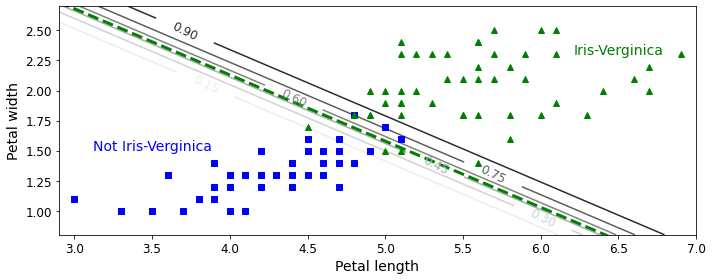

In [56]:
x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1), # reshape 안해도 결과 같은 듯
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )
# x0.shape = x1.shape = (200, 500)
X_new = np.c_[x0.ravel(), x1.ravel()]
# X_new.shape = (10000, 2)
y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs")
plt.plot(X[y==1, 0], X[y==1, 1], "g^")

left_right = np.array([2.9, 7])
print(log_reg.coef_, log_reg.intercept_)
boundary_p_zero = - (log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.Greys) # cmap="Greys"

plt.clabel(contour, inline=True, fontsize=12) # inline : Default is True
plt.plot(left_right, boundary_p_zero, "g--", linewidth=3)
plt.text(3.5, 1.5, "Not Iris-Verginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris-Verginica", fontsize=14, color="g", ha="center")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])

save_fig("logistic_regression_contour_plot")
plt.show()

### 소프트맥스 회귀
- 소프트맥스 회귀 또는 다항 로지스틱 회귀
    - **사이킷런의 Logistic Regression**은 클래스가 둘 이상일 때 기본적으로 일대다($\mbox{OvA}$) 전략 사용
- 샘플 $s$가 주어지면 소프트맥스 회귀 모델이 각 클래스 $k$ 대한 점수 $s_k(x)$를 계산
- 그 점수에 소프트맥스 함수 적용하여 각 클래스의 확률 추정
- 추정 확률이 가장 높은(그냥 가장 높은 점수를 가진) 클래스를 선택

$s_k(x) = (\theta^{(k)})^Tx$
- 각 클래스는 자신만의 파라미터 벡터 $\theta^{(k)}$가 있는데, 이 벡터들은 파라미터 행렬$\mathit{\Theta}$에 행으로 저장

#### 소프트맥스 함수

$\hat{p_k} = \sigma(s(x))_k = {\mbox{exp}(s_k(x)) \over \sum_{j=1}^K \mbox{exp}(s_j(x))}$
- $K$는 클래스 수
- $s(x)$는 샘플 $x$에 대한 각 클래스의 점수를 담은 벡터
- $\sigma(s(x))_k$는 샘플 $x$에 대한 각 클래스 점수가 주어졌을 때 이 샘플이 클래스 $k$에 속할 추정 확률

#### 소프트맥스 회귀 분류기의 예측
$\hat{y} = \mbox{ argmax}\sigma(s(x))_k = \mbox{ argmax}s_k(x) = \mbox{argmax}((\theta^{(k)})^Tx)$ (최대가 되는 $k$ 반환)

### 훈련 방법
- **크로스 엔트로피 비용함수**
- 이 비용함수를 최소화하는 것은 타깃 클래스에 대해 낮은 확률에 예측하는 모델을 억제하는 것

$J(\mathit{\Theta}) = -\frac{1}{m}\sum_{i=1}^m\sum_{k=1}^K y_k^{(i)}\mbox{log}(\hat{p}_k^{(i)})$
- 딱 두 개의 클래스가 있을 때($K = 2$) 로지스틱 회귀의 비용 함수(로그 손실)와 같아짐

#### 클래스 $K$에 대한 크로스 엔트로피의 그레이디언트 벡터

$\nabla_{\theta^{(k)}}J(\mathit{\Theta}) = \frac{1}{m}\sum_{i=1}^m(\hat{p}_k^{(i)} - y_k^{(i)})x^{(i)}$

In [57]:
X = iris["data"][:, (2, 3)] # petal length, petal width
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=10)
softmax_reg.fit(X, y)

LogisticRegression(C=10, multi_class='multinomial')

In [58]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
X_new

array([[0.        , 0.        ],
       [0.01603206, 0.        ],
       [0.03206413, 0.        ],
       ...,
       [7.96793587, 3.5       ],
       [7.98396794, 3.5       ],
       [8.        , 3.5       ]])

그림 저장: softmax_regression_contour_plot


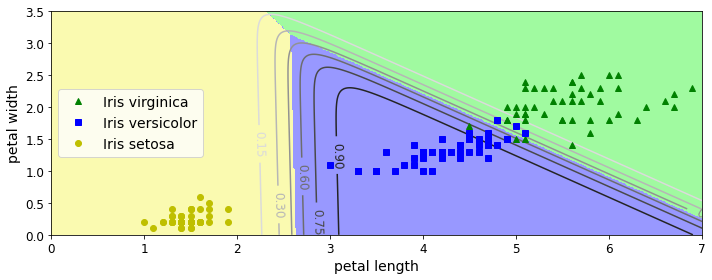

In [59]:
y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.binary)
plt.clabel(contour, inline=True, fontsize=12)
plt.xlabel("petal length", fontsize=14)
plt.ylabel("petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])

save_fig("softmax_regression_contour_plot")
plt.show()

In [60]:
print(softmax_reg.predict([[5, 2]]))
print(softmax_reg.predict_proba([[5, 2]]))

[2]
[[6.38014896e-07 5.74929995e-02 9.42506362e-01]]


---

##  ✔️ 편향/분산 트레이드오프

- 편향은 예측값과 실제값의 차이
- 오른쪽 그림의 오른쪽 그래프는 편향이 0
- 분산은 예측값의 변동성
- 오른쪽 그래프처럼들쭉날쭉 -> 변동성이 큼 -> 분산이 큼

[Bias-Variance Trade-off](https://bkshin.tistory.com/entry/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-12-%ED%8E%B8%ED%96%A5Bias%EC%99%80-%EB%B6%84%EC%82%B0Variance-Trade-off)

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=http%3A%2F%2Fcfile9.uf.tistory.com%2Fimage%2F99CDCC33599AC28F075E3C" height=350 width=350 align=left>

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FpTBCw%2FbtqygTOrG0t%2FSPwkKDINxwLLkQNcsHLvKk%2Fimg.png" align=right>


## 연습문제

### 조기 종료를 사용한 배치 경사 하강법으로 소프트맥스 회귀 구현 (사이킷런 사용 없이)

In [213]:
np.random.seed(2042)

X = iris["data"][:, (2, 3)] # petal length, petal width
y = iris["target"]
X_with_bias = np.c_[np.ones((150, 1)), X]

'''
parameter_matrix = []
for i in range(3):
    parameter_matrix.append(np.random.randn(3, 1).ravel())
parameter_matrix = np.array(parameter_matrix)
# theta_setosa = np.random.randn(3, 1).ravel()
# theta_versicolor = np.random.randn(3, 1)
# theta_virginica = np.random.randn(3, 1)
print(X_b.shape)
print(parameter_matrix.shape)

softmax_score = X_b.dot(parameter_matrix.T)
# print(softmax_score)
proba_to_k = []
for sample_s_score in softmax_score:
    sample_proba = []
    for k in range(3):
        exp_sum = np.exp(sample_s_score[0]) + np.exp(sample_s_score[1]) + np.exp(sample_s_score[2])
        sample_proba.append(np.exp(sample_s_score[k]) / np.exp(exp_sum))
    proba_to_k.append(sample_proba)
proba_to_k = np.array(proba_to_k)
'''


'\nparameter_matrix = []\nfor i in range(3):\n    parameter_matrix.append(np.random.randn(3, 1).ravel())\nparameter_matrix = np.array(parameter_matrix)\n# theta_setosa = np.random.randn(3, 1).ravel()\n# theta_versicolor = np.random.randn(3, 1)\n# theta_virginica = np.random.randn(3, 1)\nprint(X_b.shape)\nprint(parameter_matrix.shape)\n\nsoftmax_score = X_b.dot(parameter_matrix.T)\n# print(softmax_score)\nproba_to_k = []\nfor sample_s_score in softmax_score:\n    sample_proba = []\n    for k in range(3):\n        exp_sum = np.exp(sample_s_score[0]) + np.exp(sample_s_score[1]) + np.exp(sample_s_score[2])\n        sample_proba.append(np.exp(sample_s_score[k]) / np.exp(exp_sum))\n    proba_to_k.append(sample_proba)\nproba_to_k = np.array(proba_to_k)\n'

[ 0.4967 -0.1383  0.6477]

In [214]:
test_ratio = 0.2
vaildation_ratio = 0.2
total_size = len(X_with_bias)

test_size = int (total_size * test_ratio)
validation_size = int (total_size * vaildation_ratio)
train_size = total_size - test_size - validation_size

random_indices = np.random.permutation(total_size)
X_train = X_with_bias[random_indices[:train_size]]
y_train = y[random_indices[:train_size]]
X_validation = X_with_bias[random_indices[train_size:-test_size]]
y_validation = y[random_indices[train_size:-test_size]]
X_test = X_with_bias[random_indices[-test_size:]]
y_test = y[random_indices[-test_size:]]

In [215]:
def to_one_hot(y):
    n_classes = y.max() + 1
    m = len(y)
    y_one_hot = np.zeros((m, n_classes))
    y_one_hot[np.arange(m), y] = 1
    return y_one_hot

`numpy.arange([start, ], stop, [step], dtype=None)`
- start, step은 필수가 아니지만 stop은 필수
- [start, stop) 에서 step의 크기만큼 일정하게 떨어져있는 숫자들을 array형태로 반환

In [216]:
y_train[:10]

array([0, 1, 2, 1, 1, 0, 1, 1, 1, 0])

In [217]:
y_train_one_hot = to_one_hot(y_train[:10])
y_train_one_hot

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

In [218]:
y_train_one_hot = to_one_hot(y_train)
y_val_one_hot = to_one_hot(y_validation)
y_test_one_hot = to_one_hot(y_test)

In [219]:
# test
t = np.array([1, 2, 3])
np.exp(t)

array([ 2.71828183,  7.3890561 , 20.08553692])

In [220]:
def calculate_proba(logits):
    exps = np.exp(logits)
    exps_sum = np.sum(exps, axis=1, keepdims=True)
    return exps / exps_sum

[`keepdims`](https://stackoverflow.com/questions/39441517/in-numpy-sum-there-is-parameter-called-keepdims-what-does-it-do)

In [221]:
n_inputs = X_train.shape[1]
n_outputs = len(np.unique(y_train))
n_inputs, n_outputs

(3, 3)

In [222]:
eta = 0.01
iterations = 5001
epsilon = 1e-7
m = len(X_train)

theta = np.random.randn(n_inputs, n_outputs)
print(theta)

for iteration in range(iterations):
    softmax_score = X_train.dot(theta) # X_train.dot(theta.T) ? -> X_train : [sample_count, data], theta : [n_inputs(data), classes]
    softmax_proba = calculate_proba(softmax_score)
    # print((softmax_proba - y_train_one_hot).dot(X_train.T).shape)
    # print(X_train.T.dot(softmax_proba - y_train_one_hot).shape)
    if iteration % 500 == 0:
        loss = -np.mean(np.sum(y_train_one_hot * (np.log(softmax_proba + epsilon)), axis=1))
        print(iteration, loss)
    gradients = 1/m * X_train.T.dot(softmax_proba - y_train_one_hot)
    theta = theta - eta * gradients

[[ 0.11330361 -0.23452355 -0.20774285]
 [ 0.43433246 -0.66647126 -0.71757054]
 [ 1.0188498   0.41245226 -0.75018439]]
0 5.446205811872683
500 0.8350062641405651
1000 0.6878801447192402
1500 0.6012379137693313
2000 0.5444496861981873
2500 0.5038530181431525
3000 0.4729228972192248
3500 0.4482424418895776
4000 0.4278651093928793
4500 0.41060071429187134
5000 0.3956780375390373


In [223]:
theta

array([[ 3.32094157, -0.6501102 , -2.99979416],
       [-1.1718465 ,  0.11706172,  0.10507543],
       [-0.70224261, -0.09527802,  1.4786383 ]])

In [224]:
X_val_score = X_validation.dot(theta)
y_proba = calculate_proba(X_val_score)
y_predict = np.argmax(y_proba, axis=1)
print(y_predict)
print(y_validation)

accuracy_score = np.mean(y_predict == y_validation)
accuracy_score

[0 2 0 0 1 2 2 0 0 0 1 1 2 2 1 1 2 1 2 1 0 1 2 2 1 0 0 1 1 1]
[0 2 0 0 1 2 2 0 0 0 1 1 2 2 1 1 2 1 2 1 0 1 2 2 1 0 0 1 1 2]


0.9666666666666667

### $\mathcal{l}_2$ 규제 추가

- $J(\theta) = MSE(\theta) + \alpha\frac{1}{2}\sum_{i=1}^n\theta_i^2$

- 그레디언트 벡터에 $\alpha\mathbf{w}$ 추가

#### 비용함수

$J(\mathit{\Theta}) = -\frac{1}{m}\sum_{i=1}^m\sum_{k=1}^K y_k^{(i)}\mbox{log}(\hat{p}_k^{(i)})$

#### 그레이디언트 벡터

$\nabla_{\theta^{(k)}}J(\mathit{\Theta}) = \frac{1}{m}\sum_{i=1}^m(\hat{p}_k^{(i)} - y_k^{(i)})x^{(i)}$


In [225]:
eta = 0.1
n_iterations = 5001
epsilon = 1e-7
m = len(X_train)
alpha = 0.1 # 규제 하이퍼파라미터

theta = np.random.randn(n_inputs, n_outputs)
print(theta)

for iteration in range(n_iterations):
    softmax_score = X_train.dot(theta)
    softmax_proba = calculate_proba(softmax_score)
    if iteration % 500 == 0:
        entropy_loss = -np.mean(np.sum(y_train_one_hot * np.log(softmax_proba + epsilon), axis=1)) # 식 참고
        l2_loss = 1/2 * np.sum(np.square(theta[1:]))
        loss = entropy_loss + alpha * l2_loss
        print(iteration, loss)
    gradients = 1/m * X_train.T.dot(softmax_proba - y_train_one_hot) + np.r_[np.zeros([1, n_outputs]), alpha * theta[1:]] # 식 참고
    theta = theta - eta * gradients

[[ 0.63844637  0.61608862  0.53739165]
 [ 2.16968434  0.08167019 -0.04731371]
 [ 0.72490157  1.06711956  2.04506174]]
0 6.629842469083912
500 0.5339667976629506
1000 0.503640075014894
1500 0.49468910594603216
2000 0.4912968418075477
2500 0.48989924700933296
3000 0.48929905984511984
3500 0.48903512443978603
4000 0.4889173621830818
4500 0.4888643337449303
5000 0.4888403120738818


In [226]:
a = np.array([
    [1, 2],
    [2, 3],
    [3, 5]
])
print(a * a)
print(a.dot(a.T))

[[ 1  4]
 [ 4  9]
 [ 9 25]]
[[ 5  8 13]
 [ 8 13 21]
 [13 21 34]]


In [227]:
print(theta)
X_val_score = X_validation.dot(theta)
y_proba = calculate_proba(X_val_score)
y_predict = np.argmax(y_proba, axis=1)
print(y_predict)
print(y_validation)

accuracy_score = np.mean(y_validation == y_predict)
accuracy_score

[[ 4.97985231  1.04812068 -4.23604635]
 [-1.09769275  0.12541575  0.972277  ]
 [-0.43733964 -0.13642992  0.57376956]]
[0 2 0 0 1 2 2 0 0 0 1 1 2 2 1 1 2 1 2 1 0 1 2 2 1 0 0 1 1 2]
[0 2 0 0 1 2 2 0 0 0 1 1 2 2 1 1 2 1 2 1 0 1 2 2 1 0 0 1 1 2]


1.0

### 조기 종료

In [228]:
eta = 0.1
n_iterations = 5001
epsilon = 1e-7
m = len(X_train)
alpha = 0.1

theta = np.random.randn(n_inputs, n_outputs)
min_val_error = np.infty

for iteration in range(n_iterations):
    softmax_score = X_train.dot(theta)
    softmax_proba = calculate_proba(softmax_score)
    gradients = 1/m * X_train.T.dot(softmax_proba - y_train_one_hot) + np.r_[np.zeros([1, n_outputs]), alpha * theta[1:]]
    theta = theta - eta * gradients
    
    X_val_softmax_score = X_validation.dot(theta)
    X_val_softmax_proba = calculate_proba(X_val_softmax_score)
    entropy_loss = -np.mean(np.sum(y_val_one_hot * np.log(X_val_softmax_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(theta[1:]))
    loss = entropy_loss + alpha * l2_loss
    if iteration % 500 == 0:
        print(iteration, loss)
    if loss < min_val_error:
        min_val_error = loss
    else:
        print(iteration - 1, min_val_error)
        print(iteration, loss, "조기 종료")
        break

0 4.7096017363419875
500 0.5739711987633519
1000 0.5435638529109127
1500 0.5355752782580262
2000 0.5331959249285544
2500 0.5325946767399383
2765 0.5325460966791898
2766 0.5325460971327975 조기 종료


In [232]:
X_val_score = X_validation.dot(theta)
y_proba = calculate_proba(X_val_score)
y_predict = np.argmax(y_proba, axis=1)

accuracy_score = np.mean(y_validation == y_predict)
accuracy_score

1.0